In [63]:
#|default_exp init

In [64]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *


In [65]:

from fastcore.test import test_close
from math import sqrt


torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [66]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [67]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

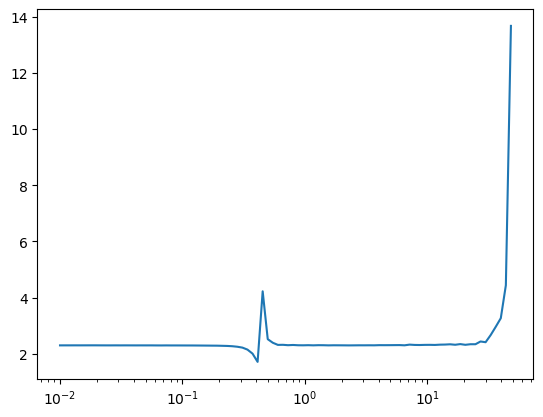

In [68]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)


In [69]:
set_seed(42)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)


accuracy,loss,epoch,train
0.164,2.464,0,train
0.173,2.237,0,eval
0.531,1.258,1,train
0.747,0.681,1,eval
0.762,0.642,2,train
0.773,0.618,2,eval


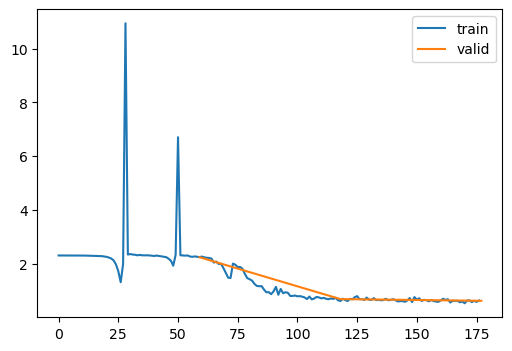

In [70]:
learn.fit(3)


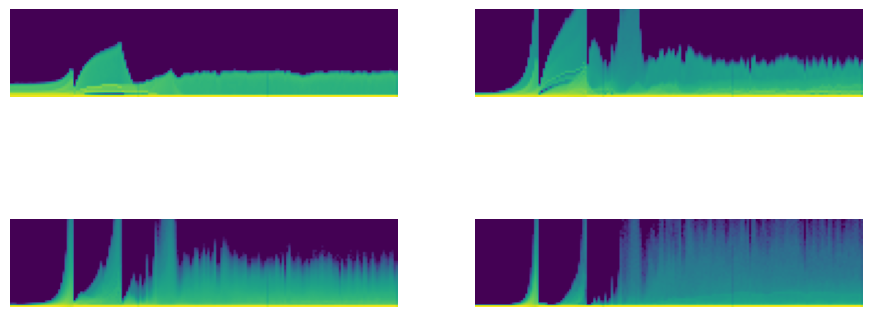

In [71]:
astats.color_dim()


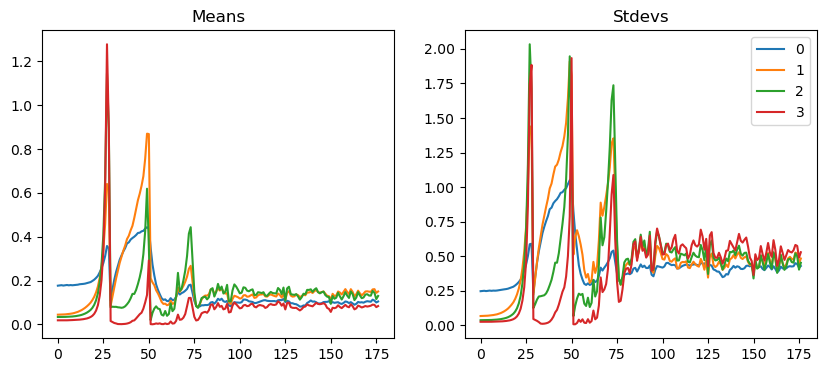

In [72]:
astats.plot_stats()


In [73]:
#|export

# Utils for memory removal from Jeremy Howard
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')
    
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()


### Initialization

We now need someway to initialize or normalize the weights in our matrix and our inputs so we dont end up with this weight explosion that we are seeing on the graphs above.

> Note on covariance
`cov = (t*v).mean() - t.mean()*v.mean(); cov`


The Kaiming initialization states that you should initialize your weights usinga zero-centered Gaussian distrobution with standard deviation of `sqrt(2/number_of_inputs)`


In [74]:
x = torch.randn(200, 100)
y = torch.randn(200)

w1 = torch.randn(100,50) * sqrt(2/100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) * sqrt(2/50)
b2 = torch.zeros(1)

def lin(x, w, b): return x @ w + b
def relu(x): return x.clamp_min(0.)



In [75]:
w1.mean(), w1.std(), sqrt(2/w1.shape[0])

(tensor(0.00), tensor(0.14), 0.1414213562373095)

In [76]:
l1 = lin(x, w1, b1)
l1.mean(),l1.std()


(tensor(0.02), tensor(1.43))

In [77]:
l2 = relu(l1)
l2.mean(),l2.std()


(tensor(0.58), tensor(0.84))

In [78]:
l3 = lin(l2, w2, b2)
l4 = relu(l3)
l4.mean(), l4.std()

(tensor(0.58), tensor(0.86))

In [79]:
get_model().apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [80]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [81]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res
     

def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [82]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

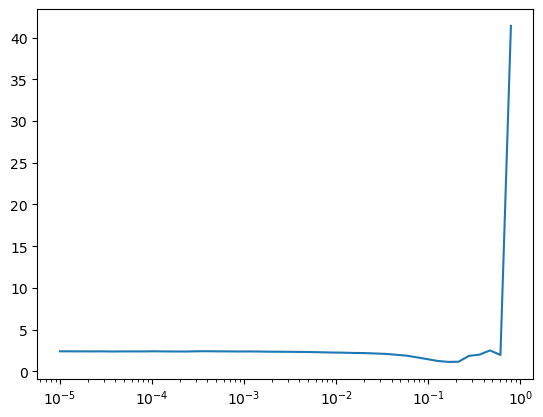

In [83]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)
MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

accuracy,loss,epoch,train
0.722,0.785,0,train
0.838,0.452,0,eval
0.853,0.400,1,train
0.857,0.392,1,eval
0.874,0.348,2,train
0.862,0.371,2,eval


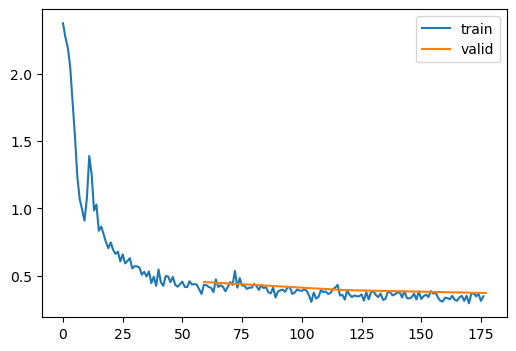

In [84]:

set_seed(42)
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=0.2, cbs=cbs)
# learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

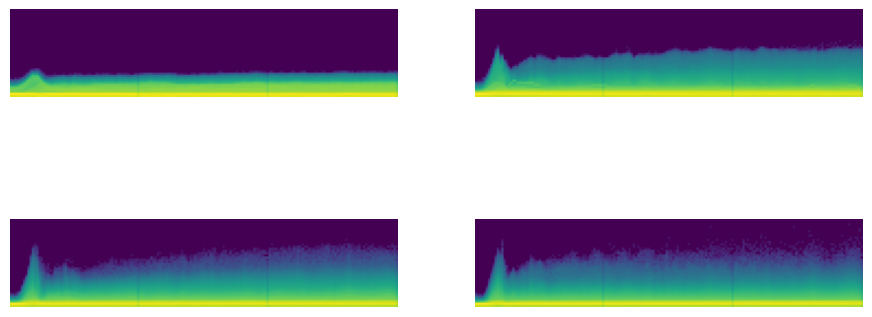

In [85]:
astats.color_dim()

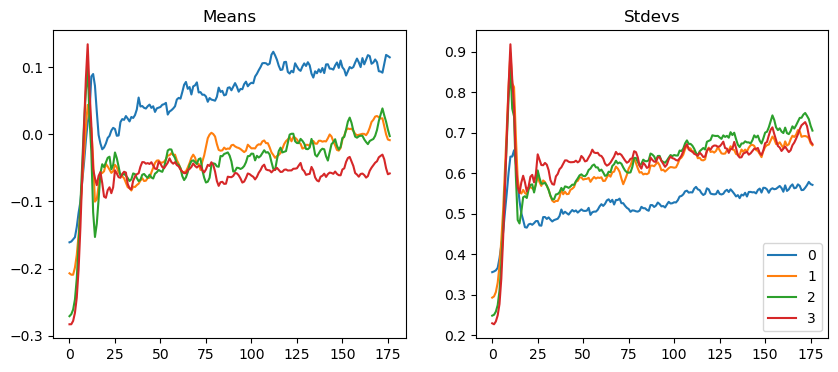

In [86]:
astats.plot_stats()


In [87]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd


(tensor(0.29), tensor(0.35))

Now we also need to normalize the inputs to our model.  Here you can see the mean and std deviation of our inputs is way off from the optimal 0, 1.  This can occur through a callback that transfroms each batch.  Or through a data transformer on the dataset.

In [88]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [89]:
def _norm(b): return (b[0]-b[0].mean())/b[0].std(),b[1]
norm = BatchTransformCB(_norm)
xnorm = _norm((xb, yb))[0]
xnorm.mean(), xnorm.std()

(tensor(    0.00), tensor(1.))

accuracy,loss,epoch,train
0.747,0.727,0,train
0.846,0.429,0,eval
0.868,0.364,1,train
0.866,0.371,1,eval
0.884,0.322,2,train
0.870,0.361,2,eval


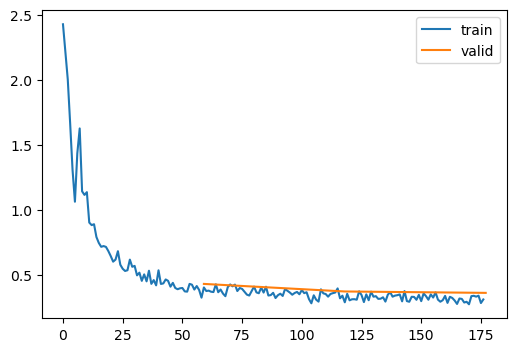

In [90]:
set_seed(42)
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

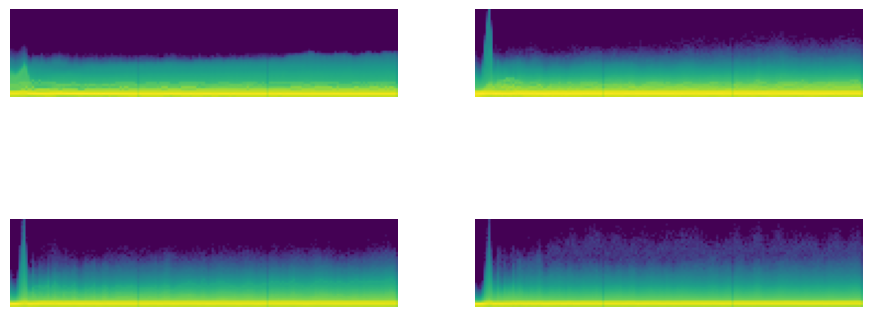

In [91]:
astats.color_dim()

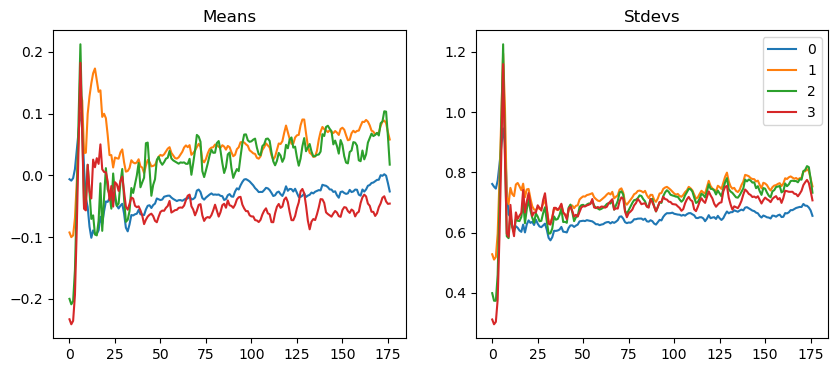

In [92]:
astats.plot_stats()

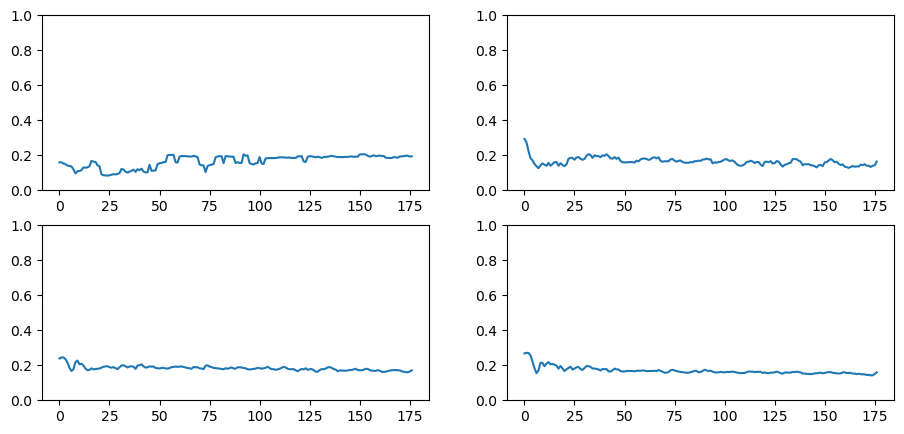

In [93]:
astats.dead_chart()

In [94]:
# Here is the method using a dataset transformer
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds2 = dsd.with_transform(transformi)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=4)
xb,yb = next(iter(dls2.train))
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=4)


xb.mean(),xb.std()


(tensor(0.01), tensor(1.00))

accuracy,loss,epoch,train
0.722,0.785,0,train
0.838,0.452,0,eval
0.853,0.400,1,train
0.857,0.392,1,eval
0.874,0.348,2,train
0.862,0.371,2,eval


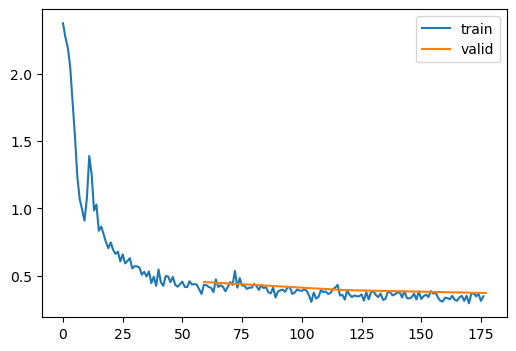

In [95]:
set_seed(42)
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

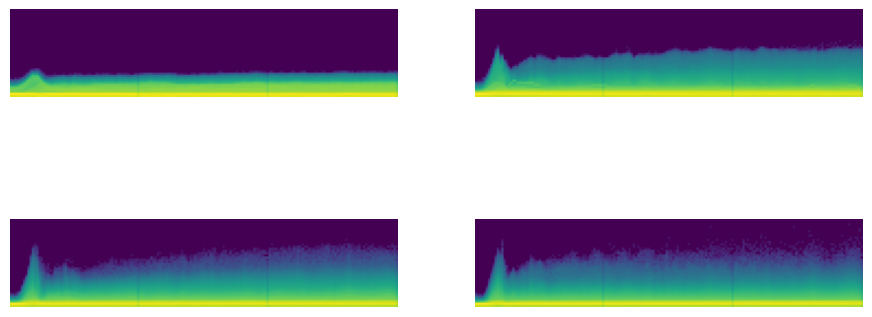

In [96]:
astats.color_dim()

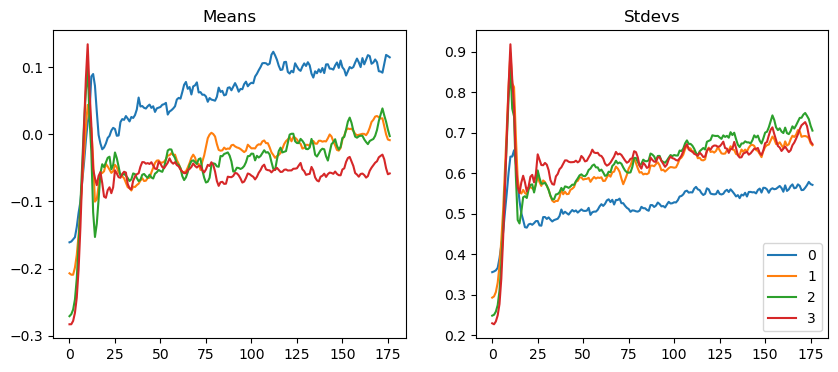

In [97]:
astats.plot_stats()

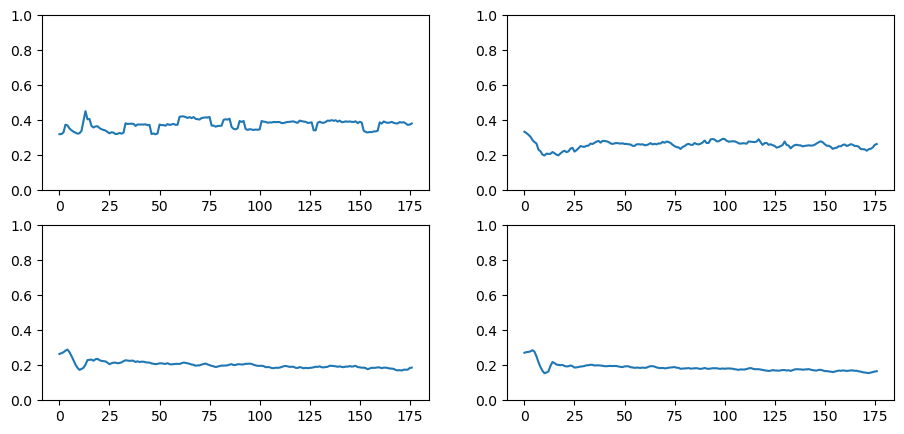

In [98]:
astats.dead_chart()

In [99]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)


### Batch Normalization

In [100]:
class LayerNorm(nn.Module):
    def __init__(self, _not_used_yet, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = 1 # Trainable values to scale layer as a whole
        self.add = 0
    
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt()) # Normalize each x in batch using its mean and variance across channels
        return x*self.mult + self.add # Scale


In [101]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)


accuracy,loss,epoch,train
0.781,0.608,0,train
0.836,0.448,0,eval
0.861,0.382,1,train
0.863,0.377,1,eval
0.879,0.330,2,train
0.863,0.368,2,eval


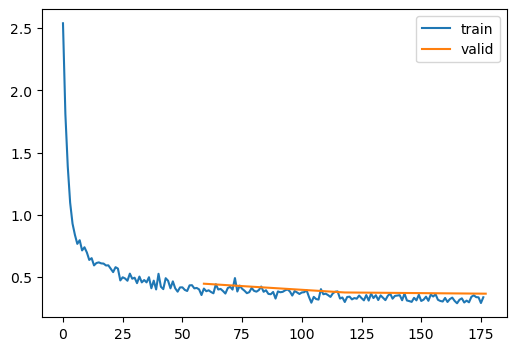

In [114]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)


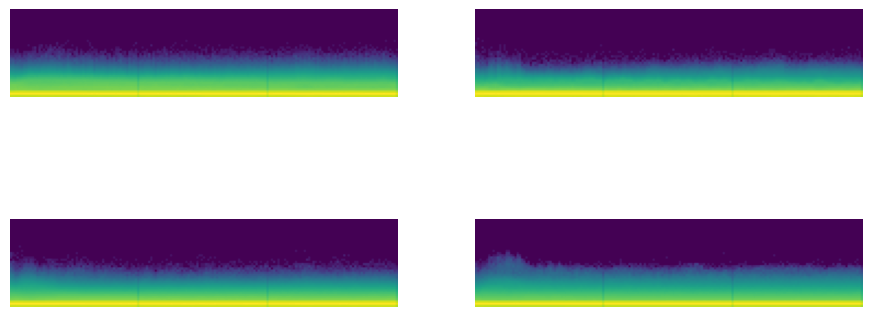

In [115]:
astats.color_dim()

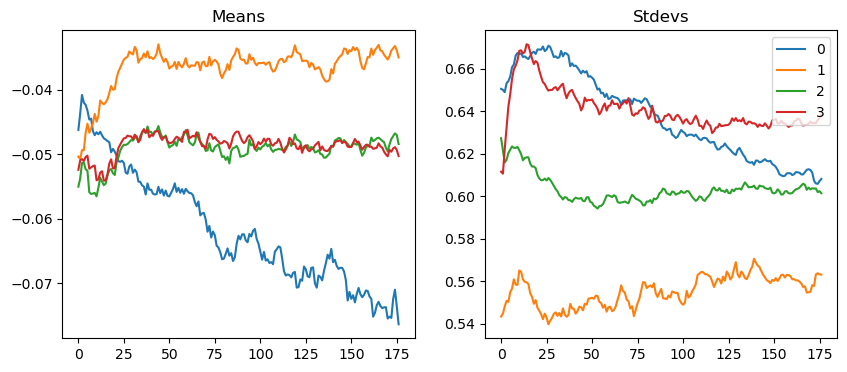

In [116]:
astats.plot_stats()

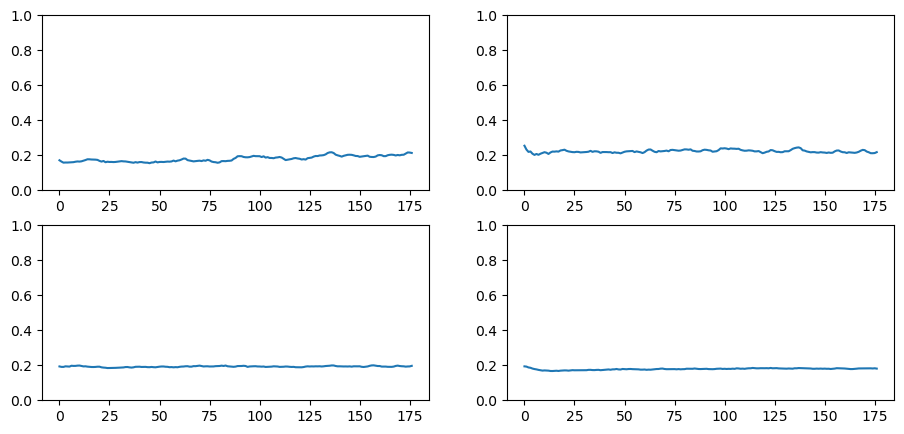

In [104]:
astats.dead_chart()

In [105]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means = self.means * (1/self.mom) + m * (self.mom) # should use a lerp here but not implemented on my macbook gpu
        self.vars = self.vars * (1/self.mom) + v * (self.vars)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

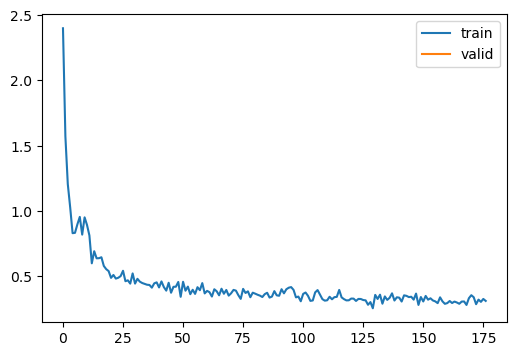

In [106]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

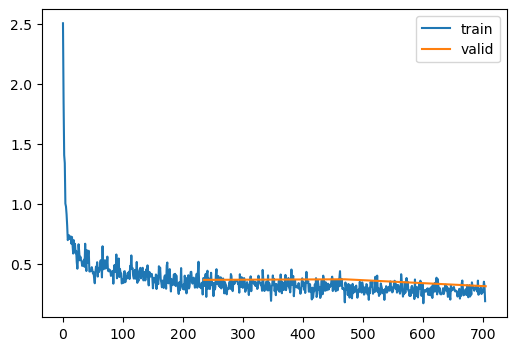

In [117]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

accuracy,loss,epoch,train
0.915,0.233,0,train
0.895,0.290,0,eval
0.919,0.221,1,train
0.896,0.285,1,eval


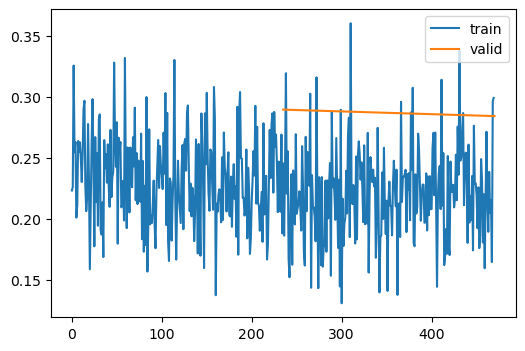

In [118]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

In [119]:
import nbdev; nbdev.nbdev_export()